In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.ndimage.measurements import label
import cv2
from util_functions import *
import glob
from collections import deque
from moviepy.editor import VideoFileClip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Not cars: 8968
Cars: 8792


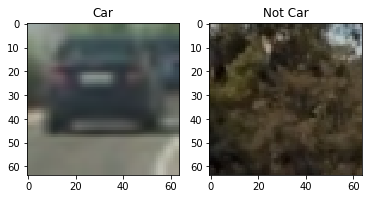

In [75]:

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

notcars = glob.glob('./non-vehicles/*/*.png')

cars = glob.glob('./vehicles/*/*.png')


print("Not cars:",len(notcars))
print("Cars:",len(cars))

car_sample_img = mpimg.imread(cars[1])
not_car_sample_img = mpimg.imread(notcars[2])
plt.subplot(121)
plt.title("Car")
plt.imshow(car_sample_img)
plt.subplot(122)
plt.title("Not Car")
plt.imshow(not_car_sample_img)
plt.show()

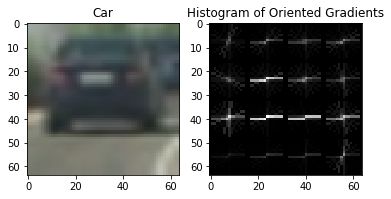

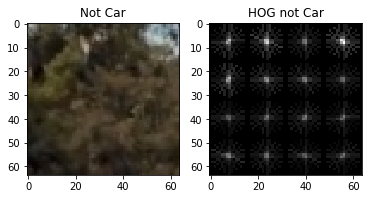

In [76]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
car_sample_img_yCrCb = cv2.cvtColor(car_sample_img, cv2.COLOR_RGB2YCrCb)
feats, hog_img = get_hog_features(car_sample_img_yCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

notcar_sample_img_yCrCb = cv2.cvtColor(not_car_sample_img, cv2.COLOR_RGB2YCrCb)
feats, notcar_hog_img = get_hog_features(notcar_sample_img_yCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)


plt.subplot(121)
plt.title("Car")
plt.imshow(car_sample_img)
plt.subplot(122)
plt.title("Histogram of Oriented Gradients")
plt.imshow(hog_img, cmap="gray")
plt.show()
plt.subplot(121)
plt.title("Not Car")
plt.imshow(not_car_sample_img)
plt.subplot(122)
plt.title("HOG not Car")
plt.imshow(notcar_hog_img, cmap="gray")
plt.show()

In [4]:
sample_size=5000
cars_sub = cars[:]
not_cars_sub = notcars[:]


car_features=extract_features(cars_sub, color_space=color_space,spatial_size=spatial_size,
                              hist_bins=hist_bins,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                              hog_channel=hog_channel,spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
notcar_features=extract_features(not_cars_sub, color_space=color_space, spatial_size=spatial_size,
                              hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                              hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


In [5]:
print(len(X[0]))


1980


In [6]:


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [7]:

#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = SVC()
#clf = GridSearchCV(svr, parameters)
#clf.fit(X_train, y_train)
#svc = clf
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
print('My SVC predicts: ', svc.score(X_test,y_test))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

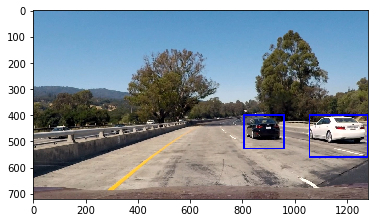

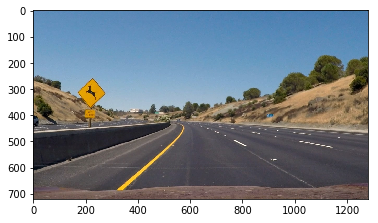

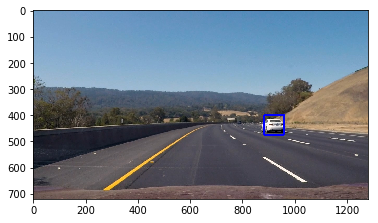

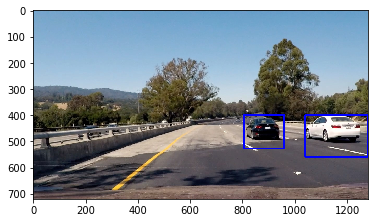

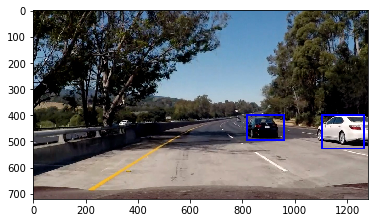

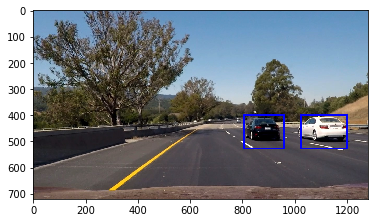

In [73]:
test_images = glob.glob("test_images/*.jpg")
for file in test_images:
    img = mpimg.imread(file)
    recent_heats = deque(maxlen=5)
    heat_threshold = 1
    labels = [0.8,1.2,1.5,2.0,2.5]
    res = find_cars(img, y_start_stop[0], y_start_stop[1], labels, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,heat_threshold,recent_heats)
    plt.imshow(res)
    plt.show()
#res = find_cars(img, 400, None, 1.5, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#plt.imshow(res)

In [63]:
def process_image(img):
    labels = [0.8,1.2,1.5,2.0,2.5]#[1.0,1.5,2.0,2.3]
    recent_heats = deque(maxlen=10)
    heat_threshold = 1
    res = find_cars(img, y_start_stop[0], y_start_stop[1], labels, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,heat_threshold,recent_heats)
    return res

In [66]:

vid_output = 'res_vid.mp4'
vid_in = VideoFileClip("project_video.mp4")#.subclip('00:00:40.00', '00:00:42.00')


count = 1
def save_frames(img): 
    cv2.imwrite("./output_images/test/test"+str(count)+".jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    out = process_image(img)
    cv2.imwrite("./output_images/test/out"+str(count)+".jpg", cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    global count
    count= count+1
    return out

vid_out = vid_in.fl_image(process_image) 
vid_out.write_videofile(vid_output, audio=False)

vid_in.reader.close()
vid_in.audio.reader.close_proc()
vid_out.reader.close()
vid_out.audio.reader.close_proc()

[MoviePy] >>>> Building video res_vid.mp4
[MoviePy] Writing video res_vid.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [25:31<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: res_vid.mp4 



In [74]:
#classifier_data = {'svc': svc, 'X_scaler': X_scaler, 'color_space': color_space, 'orient': orient,
                   'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'hog_channel': hog_channel,
                   'spatial_size': spatial_size, 'hist_bins': hist_bins, 'spatial_feat': spatial_feat,
                   'hist_feat': hist_feat, 'hog_feat': hog_feat, 'y_start_stop': y_start_stop}

# Dump the dictionary to a pickle file for future use
#pickle.dump(classifier_data,open('classifier_data_backup.p', "wb")) 

In [14]:
#classifier_data = pickle.load(open('classifier_data_backup.p', "rb"))
#svc = classifier_data['svc']
#X_scaler=classifier_data['X_scaler']